In [158]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from unidecode import unidecode

from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae, r2_score
from sklearn.model_selection import LeaveOneOut, cross_val_predict, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression, VarianceThreshold
from sklearn.linear_model import Ridge

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 1. Read data

In [159]:
era_yield = (pd.read_csv("files/crop data/national_yield.csv")
             .merge(pd.read_csv("files/ERA/processed/era_basis_expansion_all_departments.csv"), on="year", how="right"))
era_yield.head(2)

,year,harvested area [ha],yield [kg/ha],yield trend [kg/ha],yield anomaly [%],tmeansquared_-40_-63_9,tmeansquared_-40_-63_10,tmeansquared_-40_-63_11,tmeansquared_-39_-63_9,tmeansquared_-39_-63_10,...,tmeanrain_-30_-60_11,tmeanrain_-29_-60_9,tmeanrain_-29_-60_10,tmeanrain_-29_-60_11,tmeanrain_-28_-60_9,tmeanrain_-28_-60_10,tmeanrain_-28_-60_11,tmeanrain_-28_-59_9,tmeanrain_-28_-59_10,tmeanrain_-28_-59_11
0,1993,4709700,2034.763686,2135.105698,-0.046996,-0.804068,-0.551056,-0.170074,-0.954209,-0.487716,...,-0.536544,-0.909878,-0.670691,-0.412663,0.28843,-0.357500,-0.707764,-0.046632,-0.133073,-1.036243
1,1994,5112320,2188.912922,2145.631828,0.020172,-0.499194,-0.232915,0.068395,-0.662785,-0.244537,...,0.132331,0.673351,-0.155326,-0.140211,0.01030,0.212708,-0.246367,0.402256,-0.079192,-0.271787


### 2. Filter departments

- ERA data is available from September to November for 60 grid cells across the Argentinian wheat belt 
- National wheat yield forecast models are trained and validated (LOYO-CV) for each grid cell using only its respective ERA data. 
- Grid cells are then sorted in descending order by R<sup>2</sup>. 
- This is needed because later we will drop correlated features and we want to make sure to always drop the feature from the grid cell with a lower R<sup>2</sup>. 

##### 2.1 Sort grid cells by forecast performance

In [163]:
def sort_grid_cells(data, r2_threshold):
    """
    fit a national yield model for each department and returns best performances as dictionary
    params: 
        data: dataframe, with features from all municipalities
        r2_threshold: float, definition of a well-performing area
    returns:
        area_to_r2: dictionary, with keys being the municipalities and values the best model that could be fit
    """
    area_to_r2 = {}
    departments = list(set(["_".join(c.split("_")[1:3]) for c in [l for l in data.columns if l not in ['year', 'harvested area [ha]', 'yield [kg/ha]', 'yield trend [kg/ha]', 'yield anomaly [%]']]]))
    for area in departments:
        best_r2 = r2_threshold
        for no_of_features in list(range(1,7)):
            X = data.loc[:, [c for c in [l for l in data.columns if ("rain" in l) or ("tmean" in l)] if "_".join(c.split("_")[1:3]) == area]]
            y = data["yield anomaly [%]"]

            pipeline = Pipeline([('scaler', StandardScaler()), ('var', VarianceThreshold()), ('selector', SelectKBest(f_regression, k=no_of_features)), ('estimator', Ridge())])
            loo = LeaveOneOut()
            y_pred = cross_val_predict(pipeline, X, y, cv=loo)

            current_r2 = np.round(r2_score(y, y_pred), 4)
            if current_r2 > best_r2:
                print("R2 {}; area {}; features {}".format(current_r2, area, no_of_features))
                area_to_r2[area] = current_r2
                best_r2 = current_r2
                
    selected_areas = sorted(area_to_r2, key=area_to_r2.get, reverse=True)
    return selected_areas

In [164]:
selected_areas_sorted = sort_grid_cells(era_yield, -100)
selected_areas_sorted

R2 -1.8655; area -36_-61; features 1
R2 -0.1218; area -33_-62; features 1
R2 -0.103; area -34_-59; features 1
R2 -0.0352; area -34_-59; features 2
R2 0.2041; area -32_-60; features 1
R2 -0.124; area -35_-62; features 1
R2 -0.1088; area -34_-62; features 1
R2 -1.1528; area -36_-64; features 1
R2 -1.1464; area -36_-64; features 3
R2 -0.8781; area -36_-64; features 4
R2 -0.9405; area -33_-65; features 1
R2 -0.0992; area -34_-60; features 1
R2 -0.0938; area -33_-61; features 1
R2 -0.0817; area -34_-61; features 1
R2 0.099; area -32_-59; features 1
R2 -34.3068; area -28_-60; features 1
R2 -1.0175; area -37_-60; features 1
R2 -1.0004; area -37_-60; features 2
R2 -0.1403; area -36_-59; features 1
R2 -0.005; area -32_-61; features 1
R2 0.0247; area -32_-61; features 2
R2 0.1807; area -38_-63; features 1
R2 0.2304; area -38_-61; features 1
R2 -3.1806; area -38_-59; features 1
R2 -2.8521; area -38_-59; features 2
R2 -2.2557; area -38_-59; features 3
R2 -0.038; area -37_-61; features 1
R2 -0.1258

['-38_-62',
 '-31_-61',
 '-36_-62',
 '-38_-61',
 '-39_-63',
 '-33_-59',
 '-32_-60',
 '-37_-62',
 '-38_-63',
 '-32_-59',
 '-32_-61',
 '-34_-59',
 '-37_-61',
 '-38_-64',
 '-35_-64',
 '-34_-61',
 '-34_-64',
 '-33_-61',
 '-33_-60',
 '-32_-62',
 '-34_-60',
 '-34_-65',
 '-37_-64',
 '-34_-62',
 '-31_-62',
 '-35_-60',
 '-33_-62',
 '-35_-62',
 '-36_-59',
 '-33_-63',
 '-37_-63',
 '-35_-63',
 '-37_-65',
 '-36_-65',
 '-30_-62',
 '-30_-61',
 '-32_-63',
 '-31_-59',
 '-31_-63',
 '-35_-65',
 '-36_-63',
 '-36_-64',
 '-33_-65',
 '-37_-60',
 '-33_-64',
 '-36_-60',
 '-32_-64',
 '-37_-59',
 '-40_-63',
 '-34_-63',
 '-36_-61',
 '-38_-60',
 '-38_-59',
 '-38_-58',
 '-30_-60',
 '-37_-57',
 '-28_-59',
 '-35_-61',
 '-28_-60']

##### 2.2 Order features

In [165]:
era_yield_filtered = era_yield.loc[:, ["yield anomaly [%]", "year"] + [c for c in [l for l in era_yield.columns if ("rain" in l) or ("tmean" in l)] if "_".join(c.split("_")[1:3]) in selected_areas_sorted]]

# Order columns descending by performance of their department
# This is needed because we will drop correlated features later and only keep the first one
new_column_order = ["year", "yield anomaly [%]"]
for area in selected_areas_sorted:
    area_columns = [c for c in era_yield_filtered.columns if area in c]
    new_column_order = new_column_order + area_columns
era_yield_filtered = era_yield_filtered[new_column_order]
era_yield_filtered.head(2)

,year,yield anomaly [%],tmeansquared_-38_-62_9,tmeansquared_-38_-62_10,tmeansquared_-38_-62_11,rainsquared_-38_-62_9,rainsquared_-38_-62_10,rainsquared_-38_-62_11,tmeanrain_-38_-62_9,tmeanrain_-38_-62_10,...,tmeanrain_-35_-61_11,tmeansquared_-28_-60_9,tmeansquared_-28_-60_10,tmeansquared_-28_-60_11,rainsquared_-28_-60_9,rainsquared_-28_-60_10,rainsquared_-28_-60_11,tmeanrain_-28_-60_9,tmeanrain_-28_-60_10,tmeanrain_-28_-60_11
0,1993,-0.046996,-1.054889,-0.387853,0.274627,-0.541783,-0.495456,0.051294,0.498033,-0.109247,...,-0.522195,0.208817,-0.679054,0.006503,-1.016549,-0.051117,0.395684,0.28843,-0.357500,-0.707764
1,1994,0.020172,-0.824981,-0.069204,0.014797,-0.119926,-0.528206,0.155937,0.008515,0.536304,...,0.096279,0.130685,-0.671621,-0.145234,-1.110306,-0.771690,-0.309652,0.01030,0.212708,-0.246367


### 3. Train and validate national model

In [166]:
def train_and_validate_national_model(data, corr_threshold, no_features):
    """
    apply LOYO-CV on data.
    params:
        data: dataframe, contains features and targets
        corr_threshold: float, to filter correlated features before model fit
        no_features: int, number of features to train the model on
    returns (as tuple):
        features: dictionary, all features that have been selected for all folds
        rmse, current_r2, pearson_r: float, performance metrics
        y_pred, y: list, predictions and ground truth
    """
    X = data.loc[:, [c for c in data.columns if ("rain" in c) or ("tmean" in c)]]
    y = data["yield anomaly [%]"]

    # remove spatially-correlated features
    X_tmean_squared = X.loc[:, [c for c in X.columns if ("tmeansquared" in c)]]
    X_rain_squared = X.loc[:, [c for c in X.columns if ("rainsquared" in c)]]
    X_tmean_rain = X.loc[:, [c for c in X.columns if ("tmeanrain" in c)]]
    feature_sets = [X_tmean_squared, X_rain_squared, X_tmean_rain]
    to_drop =[]
    for feature_set in feature_sets:
        for month in [9, 10, 11]:
            feature_set_month = feature_set.loc[:, [c for c in feature_set.columns if (int(c.split("_")[-1]) == month)]]
            cor_matrix = feature_set_month.corr().abs().round(2)
            upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(bool))
            to_drop.append([column for column in upper_tri.columns if any(upper_tri[column] > corr_threshold)])
    to_drop = [c for k in to_drop for c in k]
    X = X.drop(to_drop, axis=1)
    
    # Leave-One-Year-Out Cross Validation
    pipeline = Pipeline([('scaler', StandardScaler()), ('selector', SelectKBest(f_regression, k=no_features)), ('estimator', Ridge())])
    loo = LeaveOneOut()
    y_pred = cross_val_predict(pipeline, X, y, cv=loo)
    output = cross_validate(pipeline, X, y, scoring="neg_mean_squared_error", cv=loo, return_estimator=True)
    
    # obtain features used in each fold
    features = dict.fromkeys(list(range(1993,2017)))
    for idx, estimator in enumerate(output['estimator']):
        selected_features = estimator.named_steps["selector"].get_feature_names_out(X.columns).tolist()
        coefficients = estimator[-1].coef_
        features[idx+1993] = dict(zip(selected_features, coefficients))
        
    
    # calculate metrics
    rmse = np.round(mse(y, y_pred, squared=False), 4)
    current_r2 = np.round(r2_score(y, y_pred), 4)
    pearson_r = np.round(pearsonr(y, y_pred)[0], 2)

    return (features, rmse, current_r2, pearson_r, y_pred, y)

In [175]:
best_rmse = 100
best_r2 = 0
for correlation_threshold in [.5]:
    for number_of_features in [4]:
        features, rmse, current_r2, pearson_r, y_pred, y = train_and_validate_national_model(era_yield_filtered, correlation_threshold, number_of_features)
        
        if rmse < best_rmse: 
            # Analyse multicollinearity
            max_vif = 0
            vif_list = []
            for fold in features:
                fold = list(features[fold].keys())
                VIF = add_constant(era_yield_filtered[fold])
                result = pd.Series([variance_inflation_factor(VIF.values, i) for i in range(VIF.shape[1])], index=VIF.columns)
                vif_result = np.round(result.loc[~result.index.str.contains("const")].max(), 2)
                if vif_result > max_vif:
                    vif_list.append(vif_result)
            
            if all(i <= 1000 for i in list(set(vif_list))):
                print(list(set(vif_list)))
                print("rmse is {}, r2 is {} for corr_threshold {} and {} features".format(rmse, current_r2, correlation_threshold, number_of_features))
                best_r2 = current_r2
                best_rmse = rmse
                feature_list = features
                best_corr = correlation_threshold
                best_f_no = number_of_features

#relevant_features = list(set([item for sublist in list(feature_list.values()) for item in sublist]))
#relevant_features
feat_coef = pd.DataFrame(feature_list).mean(axis=1)
feat_coef

[1.69, 1.3]
rmse is 0.0716, r2 is 0.7182 for corr_threshold 0.5 and 4 features


tmeansquared_-38_-62_11   -0.011541
tmeanrain_-38_-62_11       0.041185
rainsquared_-31_-61_11    -0.054258
rainsquared_-36_-62_9      0.081810
tmeanrain_-31_-61_10      -0.002547
dtype: float64

### 4. Visualize estimates

#### 4.1 Read shapefiles to plot map

In [176]:
era_plot = gpd.read_file('files/shapefiles/era_plot_high_resolution.shp')
era_plot_grid = gpd.read_file('files/shapefiles/era_plot_grid.shp')

In [223]:
locations = pd.DataFrame(index=(0, 1, 2), data=list(set(["_".join(c.split("_")[1:3]) for c in feat_coef.index.tolist()])))
locations = locations[0].str.split("_", expand=True)
locations.columns = ["lat", "lon"]
locations = gpd.GeoDataFrame(locations, geometry=gpd.points_from_xy(locations["lon"], locations["lat"], crs="EPSG:4326"))


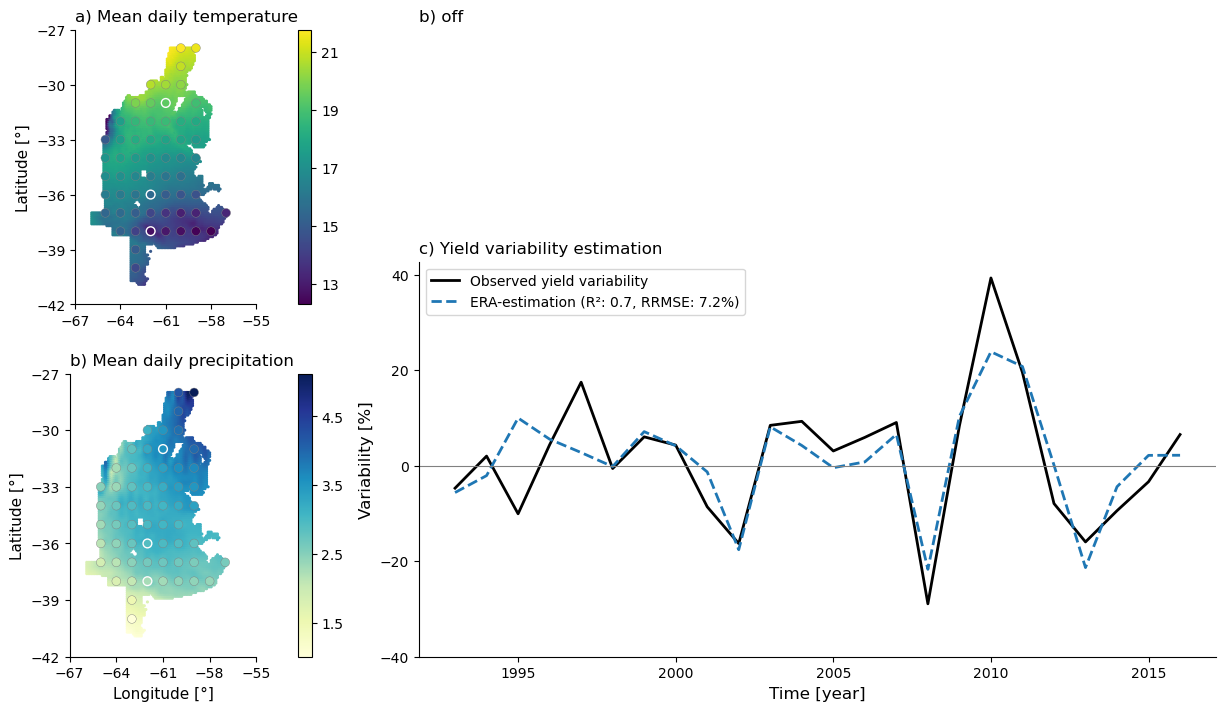

In [228]:
# Create subplots
fig, axd = plt.subplot_mosaic([['upper left', 'upper right'],
                               ['upper left', 'lower right'],
                               ['lower left', 'lower right'],
                               ['lower left', 'lower right']],
                              figsize=(15, 7), layout="constrained", width_ratios=[0.4, 0.6], height_ratios=[0.4, 0.1, 0.25, 0.25])

era_plot.plot(column="tmean", ax=axd['upper left'], markersize=1.5, legend=True, legend_kwds={'ticks': list(range(13,22,2))})
era_plot_grid.plot(column="tmean", ax=axd['upper left'], markersize=40, edgecolor="grey", linewidth=.3, legend=False)
locations.plot(ax=axd['upper left'], markersize=40, edgecolor="white", facecolor="none", linewidth=1, legend=False)
axd['upper left'].set_title("a) Mean daily temperature", loc="left");
axd['upper left'].set_ylabel("Latitude [°]", size=11);
#axd['upper left'].set_xlabel("Longitude [°]", size=11);
axd['upper left'].set_yticks(list(range(-42, -24, 3)))
axd['upper left'].set_xticks([-67, -64, -61, -58, -55])
axd['upper left'].spines[['right', 'top']].set_visible(False)
era_plot.plot(column="rain", ax=axd['lower left'], legend=True, markersize=1.5, cmap="YlGnBu", legend_kwds={'ticks': list(np.arange(1.5,5.5,1))})
era_plot_grid.plot(column="rain", ax=axd['lower left'], markersize=40, edgecolor="grey", linewidth=.3, cmap="YlGnBu", legend=False)
locations.plot(ax=axd['lower left'], markersize=40, edgecolor="white", facecolor="none", linewidth=1, legend=False)
axd['lower left'].set_title("b) Mean daily precipitation", loc="left");
axd['lower left'].set_ylabel("Latitude [°]", size=11);
axd['lower left'].set_xlabel("Longitude [°]", size=11);
axd['lower left'].set_yticks(list(range(-42, -24, 3)))
axd['lower left'].set_xticks([-67, -64, -61, -58, -55])
axd['lower left'].spines[['right', 'top']].set_visible(False)

axd["upper right"].axis("off")
axd["upper right"].set_title("b) off", loc="left")

# Figure c) Observed and predicted yield anomaly by year
loc3 = "lower right"
(features, rmse, current_r2, pearson_r, y_pred, y) = train_and_validate_national_model(era_yield_filtered, best_corr, best_f_no)
axd[loc3].plot(era_yield_filtered["year"], 100*y, color="black", label="Observed yield variability", linewidth=2);
axd[loc3].plot(era_yield_filtered["year"], 100*y_pred, linestyle="dashed", label="ERA-estimation (R\u00b2: {}, RRMSE: {}%)".format(round(best_r2, 1), round(100*best_rmse, 1)), linewidth=2);
axd[loc3].set_ylabel("Variability [%]", size=12)
axd[loc3].set_title("c) Yield variability estimation", loc="left", size=12);
axd[loc3].set_xlabel("Time [year]", size=12)
#axd[loc3].set_xticks(list(range(1994, 2017, 2)))
#axd[loc3].grid(axis="x", linewidth=.3, color="#A8A8A8")
axd[loc3].set_yticks([40, 20, 0, -20, -40])
axd[loc3].spines[['right', 'top']].set_visible(False)
axd[loc3].axhline(0, 0, color="grey", linewidth=.8)
axd[loc3].legend(loc="upper left");

#plt.tight_layout()
plt.show()

#### 4.2 Create plot

### 5. Drop unselected features and export dataset

In [24]:
era_yield_filtered_features = era_yield_filtered.assign(model="ERA", init_month=12).set_index(["model", "year", "init_month", "yield anomaly [%]"])[relevant_features].reset_index(drop=False)

era_yield_filtered_features.to_csv("files/ERA/processed/era_final_features.csv", index=False)